In [12]:

from utils.agent_helper import create_agent, agent_node, create_team_supervisor
from utils.models import REASONING_LLM
from utils.prompts import RESEARCH_AGENT_PROMPT, SUPERVISOR_PROMPT
from utils.graphs import *

from langchain_core.tools import tool

import functools
from typing import Annotated


In [13]:
from dotenv import load_dotenv

load_dotenv()

True

### research agent

In [18]:
# paper research tools
paper_chain = create_paper_rag()
@tool
def retrieve_paper_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about the papers provided."""
  return paper_chain.invoke({"question" : query})['response']


textbook_chain = create_textbook_rag()
@tool
def retrieve_textbook_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about the book 'Textbook of Diabetes'."""
  return textbook_chain.invoke({"question" : query})['response']

In [19]:
# research node
research_agent = create_agent(
    REASONING_LLM,
    [retrieve_paper_information, retrieve_textbook_information],
    RESEARCH_AGENT_PROMPT,
)
research_node = functools.partial(agent_node, agent=research_agent, name="LocalInformationRetriever")

# query node
query_node = get_scholar_query_node()

In [20]:
supervisor_agent = create_team_supervisor(
    REASONING_LLM,
    SUPERVISOR_PROMPT,
    ["ScholarQuery", "LocalInformationRetriever"],
)

/Users/zding/Documents/aibootcamp/code/AIE4-DemoDay/utils/agent_helper.py:90: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 0.3.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [ ]:
research_chain = compile_graph(research_node, query_node, supervisor_agent)

In [26]:
for s in research_chain.stream(
    "what caused diabetes?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'Supervisor': {'next': 'ScholarQuery'}}
---
{'Query': {'messages': [HumanMessage(content='The research paper titled "Social Determinants of Health and Structural Inequities-Root Causes of Diabetes Disparities" discusses how social determinants of health (SDOH) and structural inequities are the root causes of diabetes disparities. The paper emphasizes that historically marginalized groups, such as racial and ethnic minorities and those with lower socioeconomic status, bear a disproportionate burden of diabetes and its associated complications. Factors such as socioeconomic status, neighborhood and physical environment, food environment, health care, and social context are highlighted as key contributors to diabetes outcomes. The paper calls for addressing SDOH at the structural and systems level to achieve health equity and improve outcomes, particularly for marginalized communities.', additional_kwargs={}, response_metadata={}, name='ScholarQuery')]}}
---
{'Supervisor': {'next': 'Loca

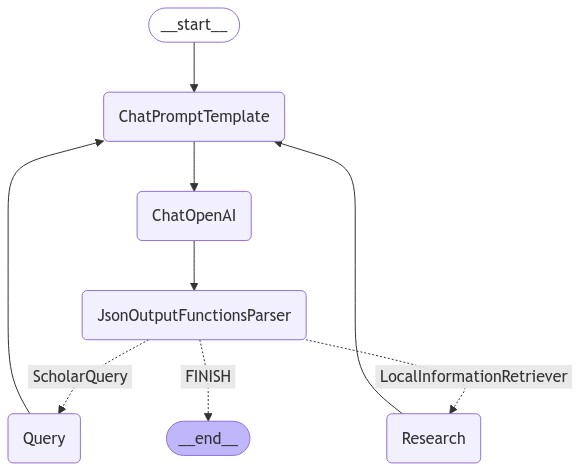

In [27]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass